# Time series clustering exercise

# Data

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

The data is on the github repo. Each file is the economic census for 1 year. 
Download it programmatically and move it to PUIdata

 Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


In [3]:
import os
import glob
import zipfile
import urllib.request as urllib
import geopandas as gpd
import zipfile
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster as scp
from sklearn.metrics import silhouette_score
import choroplethNYC as cp
import pylab as pl

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Download the NYC zipcodes shapefile.

In [4]:
url = 'https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip'
urllib.urlretrieve(url, os.getenv('PUIDATA') + '/zipcode.zip')

('/nfshome/ql459/PUIdata/zipcode.zip',
 <http.client.HTTPMessage at 0x7f7916663da0>)

In [5]:
unzip = zipfile.ZipFile(os.getenv('PUIDATA') + '/zipcode.zip')
unzip.extractall(os.getenv('PUIDATA') + '/')

In [4]:
zipshp = gpd.GeoDataFrame.from_file(os.getenv('PUIDATA') + '/ZIP_CODE_040114.shp')

In [5]:
print(zipshp.crs)

{'lat_0': 40.16666666666666, 'lat_2': 41.03333333333333, 'x_0': 300000, 'lon_0': -74, 'y_0': 0, 'lat_1': 40.66666666666666, 'datum': 'NAD83', 'no_defs': True, 'units': 'us-ft', 'proj': 'lcc'}


In [6]:
zipshp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [7]:
zipshp = zipshp.drop_duplicates('ZIPCODE')

In [8]:
zipshp.shape

(248, 13)

### census bureau business data for all years 1993-2014

In [107]:
!git clone https://github.com/fedhere/PUI2018_fb55
!unzip PUI2018_fb55/HW12_fb55/\*.zip -d $PUIDATA
!rm -rf PUI2018_fb55

Cloning into 'PUI2018_fb55'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 1290 (delta 22), reused 11 (delta 4), pack-reused 1249
Receiving objects: 100% (1290/1290), 67.92 MiB | 41.64 MiB/s, done.
Resolving deltas: 100% (571/571), done.
Checking connectivity... done.
Checking out files: 100% (266/266), done.
Archive:  PUI2018_fb55/HW12_fb55/zbp11totals.zip
  inflating: /nfshome/ql459/PUIdata/zbp11totals.txt  

Archive:  PUI2018_fb55/HW12_fb55/zbp08totals.zip
  inflating: /nfshome/ql459/PUIdata/zbp08totals.txt  

Archive:  PUI2018_fb55/HW12_fb55/zbp06totals.zip
  inflating: /nfshome/ql459/PUIdata/zbp06totals.txt  

Archive:  PUI2018_fb55/HW12_fb55/zbp99totals.zip
  inflating: /nfshome/ql459/PUIdata/zbp99totals.txt  

Archive:  PUI2018_fb55/HW12_fb55/zbp13totals.zip
  inflating: /nfshome/ql459/PUIdata/zbp13totals.txt  

Archive:  PUI2018_fb55/HW12_fb55/zbp03totals.zip
  inflating: /nf

In [10]:
fnames = glob.glob('zbp*.txt')
fnames.sort()
fnames = fnames[-6:] + fnames[:-6]

In [11]:
fnames

['zbp94totals.txt',
 'zbp95totals.txt',
 'zbp96totals.txt',
 'zbp97totals.txt',
 'zbp98totals.txt',
 'zbp99totals.txt',
 'zbp00totals.txt',
 'zbp01totals.txt',
 'zbp02totals.txt',
 'zbp03totals.txt',
 'zbp04totals.txt',
 'zbp05totals.txt',
 'zbp06totals.txt',
 'zbp07totals.txt',
 'zbp08totals.txt',
 'zbp09totals.txt',
 'zbp10totals.txt',
 'zbp11totals.txt',
 'zbp12totals.txt',
 'zbp13totals.txt',
 'zbp14totals.txt']

In [12]:
nyczips = zipshp['ZIPCODE'].unique()
dfs = pd.DataFrame(nyczips, columns=['zip'])
dfs['zip'] = dfs['zip'].astype(int)

for f in fnames:
    df = pd.read_csv(open(f))

    df.columns = [c.lower() for c in df.columns]

    df = df[[str(z) in nyczips for z in df['zip']]]

    df = df[['zip', 'est']]
    dfs = dfs.merge(df, on='zip', how='left')

In [13]:
dfs.head()

,zip,est_x,est_y,est_x,est_y,est_x,est_y,est_x,est_y,est_x,...,est_y,est_x,est_y,est_x,est_y,est_x,est_y,est_x,est_y,est
0,11436,51.0,50.0,53.0,51.0,51.0,58.0,65.0,57.0,78.0,...,82.0,80.0,84.0,90.0,92.0,98.0,101.0,95.0,99.0,109.0
1,11213,406.0,420.0,433.0,456.0,476.0,473.0,477.0,493.0,546.0,...,556.0,565.0,556.0,592.0,621.0,675.0,674.0,726.0,755.0,772.0
2,11212,505.0,494.0,502.0,527.0,519.0,541.0,520.0,527.0,577.0,...,587.0,570.0,587.0,602.0,647.0,699.0,713.0,721.0,731.0,752.0
3,11225,381.0,387.0,388.0,410.0,416.0,409.0,417.0,422.0,479.0,...,491.0,499.0,514.0,520.0,543.0,580.0,597.0,623.0,673.0,696.0
4,11218,985.0,1015.0,1049.0,1075.0,1118.0,1149.0,1161.0,1180.0,1228.0,...,1332.0,1331.0,1377.0,1397.0,1457.0,1474.0,1523.0,1605.0,1687.0,1736.0


In [14]:
dfs.set_index('zip', inplace=True)
dfs.columns = [str(i) for i in range(1994, 2015)]

In [15]:
dfs.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
11436,51.0,50.0,53.0,51.0,51.0,58.0,65.0,57.0,78.0,74.0,...,82.0,80.0,84.0,90.0,92.0,98.0,101.0,95.0,99.0,109.0
11213,406.0,420.0,433.0,456.0,476.0,473.0,477.0,493.0,546.0,569.0,...,556.0,565.0,556.0,592.0,621.0,675.0,674.0,726.0,755.0,772.0
11212,505.0,494.0,502.0,527.0,519.0,541.0,520.0,527.0,577.0,581.0,...,587.0,570.0,587.0,602.0,647.0,699.0,713.0,721.0,731.0,752.0
11225,381.0,387.0,388.0,410.0,416.0,409.0,417.0,422.0,479.0,488.0,...,491.0,499.0,514.0,520.0,543.0,580.0,597.0,623.0,673.0,696.0
11218,985.0,1015.0,1049.0,1075.0,1118.0,1149.0,1161.0,1180.0,1228.0,1247.0,...,1332.0,1331.0,1377.0,1397.0,1457.0,1474.0,1523.0,1605.0,1687.0,1736.0


# Data cleaning

you may need to clean your data: for some NYC zip codes there may be no info
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: read the instructions below on pre-processing. Afte rthat:

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



## TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means
    in **a few** clusters (as discussed there is no real good, sound way to 
    decide what a good number is here. try a few options, keeping in mind 
    a few is more than a couple, but i recommand you stay within the 
    single digit numbers)
    
    3. plot the cluster centers (if you used K means those are the means of 
    the clusters). you can plot for example the cluster centers overlayed on 
    each time series (using the alpha channel to control the opacity in the 
    plot may be helpful here).
    
    4. Use another clustering algorithm (of your choice)
    
    5. overlay your data on a NYC map: you can use shapefiles for the 
    zip codes and different colors for different clusters
    
    6. Compare the results of the 2 algorithms
    
    7. attempt an interpretation. this is dangerous ground: clustering is 
    an exploratory tool so you do not want to jump to conclusions because 
    you see some clusters! but seeing structure in your data can inform 
    your next moves as an investigator. 
    

Note on preprocessing: the preparation of these data should include the "standardization" of the time seris. 
*Always when you apply a moachine learning model you should standardize the data or whiten it.*
These operations may be complicated preprocessing operation, they can for example invoke PCA, and they are aimed at removing covariance in the feature space.

The simplest version of whitening *standardizes each feature*" from every column (feature) you subtract the mean and you divide it by the standard deviation.

But the time series preprocessing is different if you want to use each time stamp as feature: because you want to maintain the coherence of the data, i.e. you **do not want** to treat each feature as an independent feature! the pattenrs in the time series are what you are clustering on (time series goes up and down, creating a pattern) and those patterns would be lost by whitening.

*So when you cluster or otherwise use a time series in a model, using each timestamp as a feature, you want to standardize the observations, not the features.* 

**From each row of your table (observation, in this case each zipcode) subtract the mean and you divide the row by the standard deviation.**

In [16]:
import geopandas as gp
nyczipsshp = gp.read_file(os.getenv("PUIDATA") + "/ZIP_CODE_040114.shp")
#nyczipsshp.plot()
#nyczipsshp.drop_duplicates("ZIPCODE").plot()
#nyczipsshp
print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "POLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
nyczips = nyczipsshp.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

ZIPCODES: 248 POLYGONS: 263 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 263


In [17]:
import geopandas as gp
nyczipsshp = gp.read_file(os.getenv("PUIDATA") + "/ZIP_CODE_040114.shp")
#nyczipsshp.plot()
#nyczipsshp.drop_duplicates("ZIPCODE").plot()
#nyczipsshp
print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "POLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
nyczips = nyczipsshp.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

ZIPCODES: 248 POLYGONS: 263 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 263


In [18]:
cbs = dfs.copy()

In [19]:
cbs.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
11436,51.0,50.0,53.0,51.0,51.0,58.0,65.0,57.0,78.0,74.0,...,82.0,80.0,84.0,90.0,92.0,98.0,101.0,95.0,99.0,109.0
11213,406.0,420.0,433.0,456.0,476.0,473.0,477.0,493.0,546.0,569.0,...,556.0,565.0,556.0,592.0,621.0,675.0,674.0,726.0,755.0,772.0
11212,505.0,494.0,502.0,527.0,519.0,541.0,520.0,527.0,577.0,581.0,...,587.0,570.0,587.0,602.0,647.0,699.0,713.0,721.0,731.0,752.0
11225,381.0,387.0,388.0,410.0,416.0,409.0,417.0,422.0,479.0,488.0,...,491.0,499.0,514.0,520.0,543.0,580.0,597.0,623.0,673.0,696.0
11218,985.0,1015.0,1049.0,1075.0,1118.0,1149.0,1161.0,1180.0,1228.0,1247.0,...,1332.0,1331.0,1377.0,1397.0,1457.0,1474.0,1523.0,1605.0,1687.0,1736.0


In [20]:
# 20 years of data and 263 zipcodes
cbs.shape

(248, 21)

In [21]:
cleancsb = cbs.dropna(how = 'all', axis = 0)
cleancsb = cleancsb.fillna(value = 0)
cleancsb.shape

(245, 21)

In [22]:
#cleaning all missing values
cleancsb.shape

(245, 21)

In [41]:
#then the standardization will look like:
vals = ((cleancsb.T - cleancsb.mean(1)) / cleancsb.std(1)).T


In [42]:
vals.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
11436,-1.296083,-1.347340,-1.193568,-1.296083,-1.296083,-0.937280,-0.578478,-0.988538,0.087870,-0.117160,...,0.292900,0.190385,0.395415,0.702960,0.805475,1.113020,1.266793,0.959248,1.164278,1.676853
11213,-1.433782,-1.305462,-1.186307,-0.975496,-0.792181,-0.819678,-0.783015,-0.636364,-0.150580,0.060232,...,-0.058923,0.023569,-0.058923,0.271044,0.536850,1.031799,1.022634,1.499252,1.765058,1.920875
11212,-1.077974,-1.210216,-1.114040,-0.813490,-0.909666,-0.645182,-0.897644,-0.813490,-0.212389,-0.164301,...,-0.092169,-0.296543,-0.092169,0.088161,0.629152,1.254297,1.422605,1.518781,1.639001,1.891464
11225,-1.223282,-1.159696,-1.149098,-0.915948,-0.852361,-0.926545,-0.841764,-0.788775,-0.184704,-0.089324,...,-0.057531,0.027251,0.186217,0.249804,0.493552,0.885668,1.065830,1.341371,1.871258,2.115007
11218,-1.474935,-1.336988,-1.180649,-1.061095,-0.863371,-0.720826,-0.665648,-0.578281,-0.357567,-0.270200,...,0.120649,0.116050,0.327569,0.419533,0.695427,0.773596,0.998909,1.375964,1.753018,1.978331


vals.mean(axis=1) should return 0 (or something very small) everywhere

vals.mean(axis=1).shape should be (260,)

vals.std(axis=1) should return 1 everywhere

vals.std(axis=1).shape

### cluster the NUMBER OF ESTABLISHMENTS time series with K-means and plot the cluster centers

In [26]:
#define the kmean plot function and try cluster with 3，5，7
def kmeansplot(nc, data, zipshp, random_state=444):
    km = KMeans(n_clusters=nc, random_state=random_state).fit(vals)
    km_label_nc = pd.DataFrame(km.labels_)
    pl.figure(figsize=(20,30))
    
    for i in range(nc):
        kdf = data[km.labels_ == i]
        means = kdf.mean(axis=0)
        
        pl.subplot(7,2,i+1)
        for j in range(len(kdf)):
            pl.plot(range(21), data.irow(j)[:21],'black', alpha=0.3)
        pl.plot(range(21), means[:21], 'blue', alpha=0.5,linewidth=6)
        pl.xticks(arange(0,21,5), arange(1994,2015,5), rotation=45)
        pl.title('Cluster:%s'%i)
    
    km_label_zip = km_label_nc.copy()
    km_label_zip.index = vals.index
    km_label_zip.columns= ['km%d'%nc]
    km_label_zip.reset_index(inplace=True)
    km_label_zip.rename(columns = {'zip' : 'ZIPCODE'}, inplace=True)
    km_label_zip['ZIPCODE'] = km_label_zip['ZIPCODE'].astype('str')
    nycshp = pd.merge(zipshp,km_label_zip, on='ZIPCODE',how='inner')
    
    #ax = cp.choroplethNYC(nycshp, column='km%d'%nc,kind='continuous', cmap="Blues")
    pl.figure(figsize=(12,12))
    ax = pl.subplot(111)
    nycshp.plot(column='km%d'%nc,edgecolor='black', cmap="Blues", categorical=True, legend=True,ax=ax)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:13: FutureWarning: irow(i) is deprecated. Please use .iloc[i]


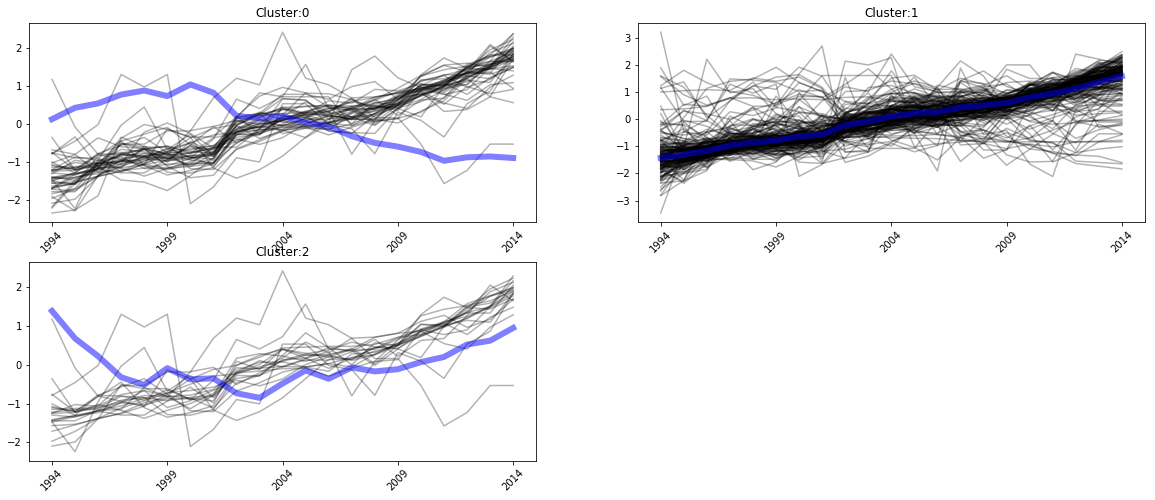

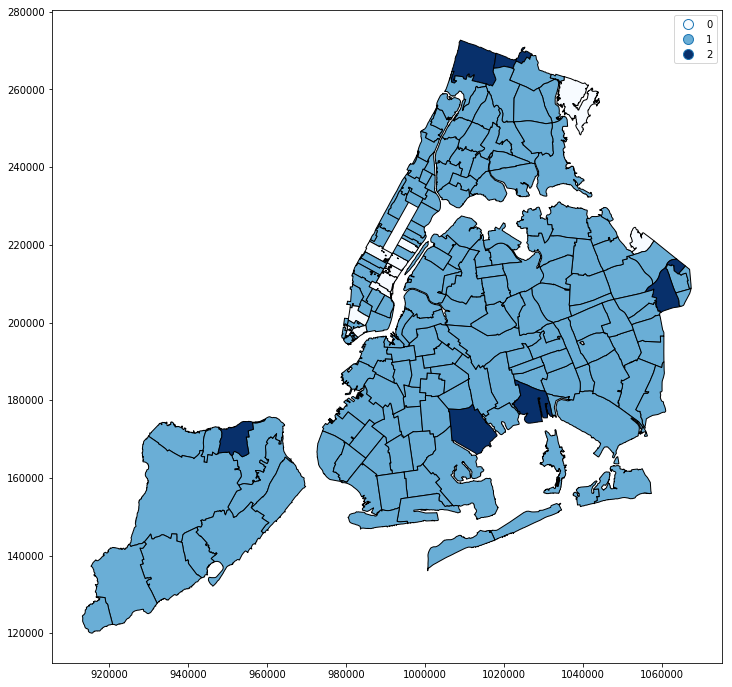

In [27]:
kmeansplot(3,vals, zipshp)

### figure 1: k-mean clustering of 3 for the establishments time series. 1,2 are increasing trend and 0 is decreasing trend. cloropleth of cluster centers for 3 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. there are three types of blue

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:13: FutureWarning: irow(i) is deprecated. Please use .iloc[i]


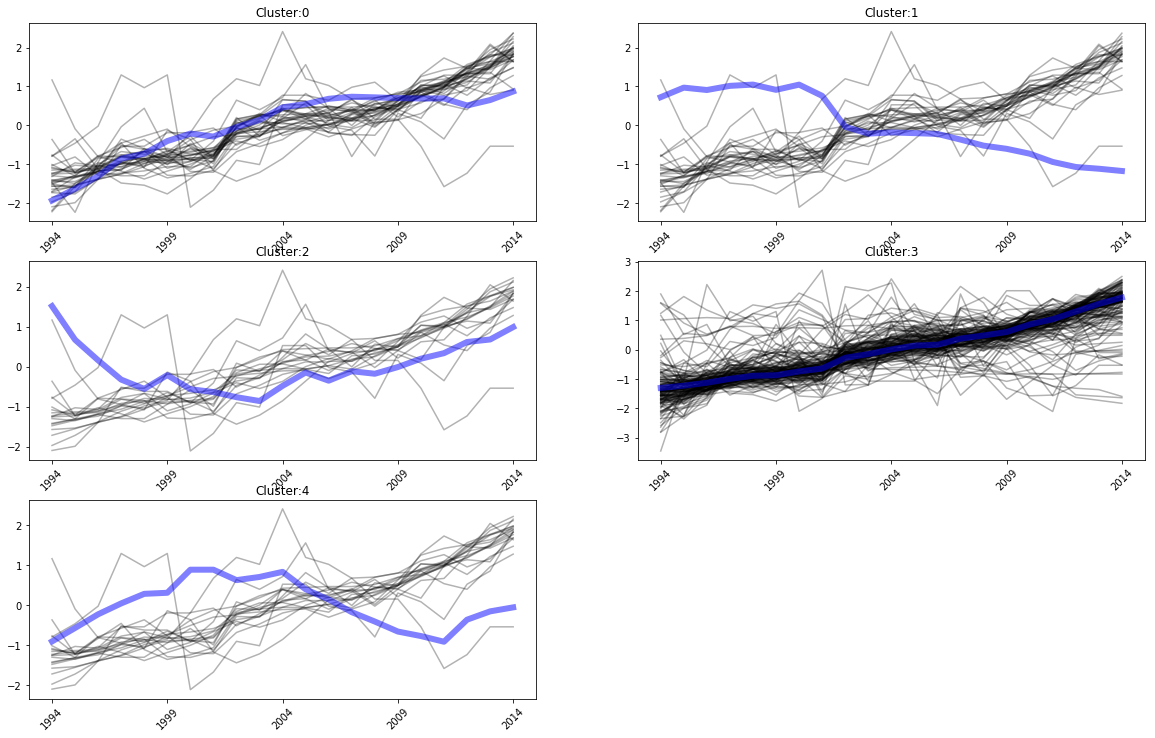

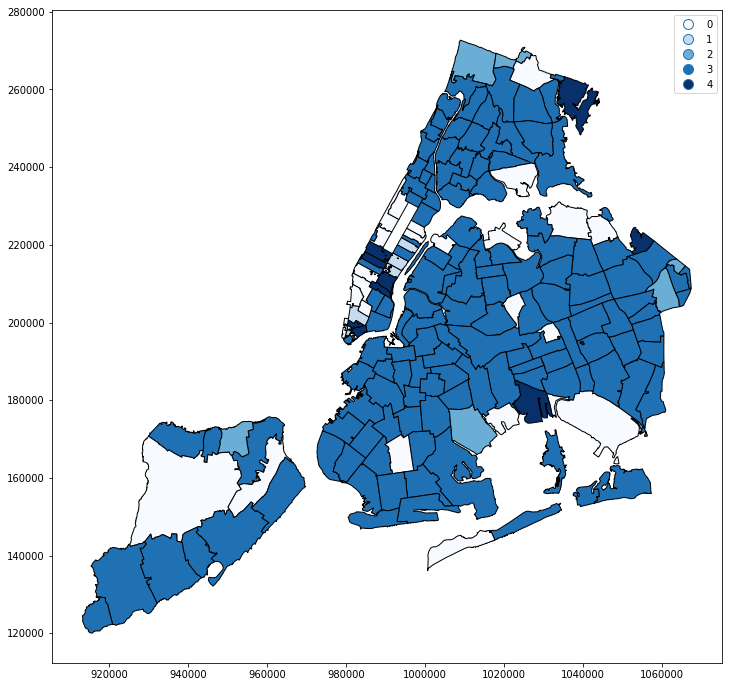

In [28]:
kmeansplot(5,vals,zipshp)

### figure 2: k-mean clustering of 5 for the establishments time series. 0,3 are increasing trend and 1 is decreasing trend. cloropleth of cluster centers for 5 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster., there are five types of blue

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:13: FutureWarning: irow(i) is deprecated. Please use .iloc[i]


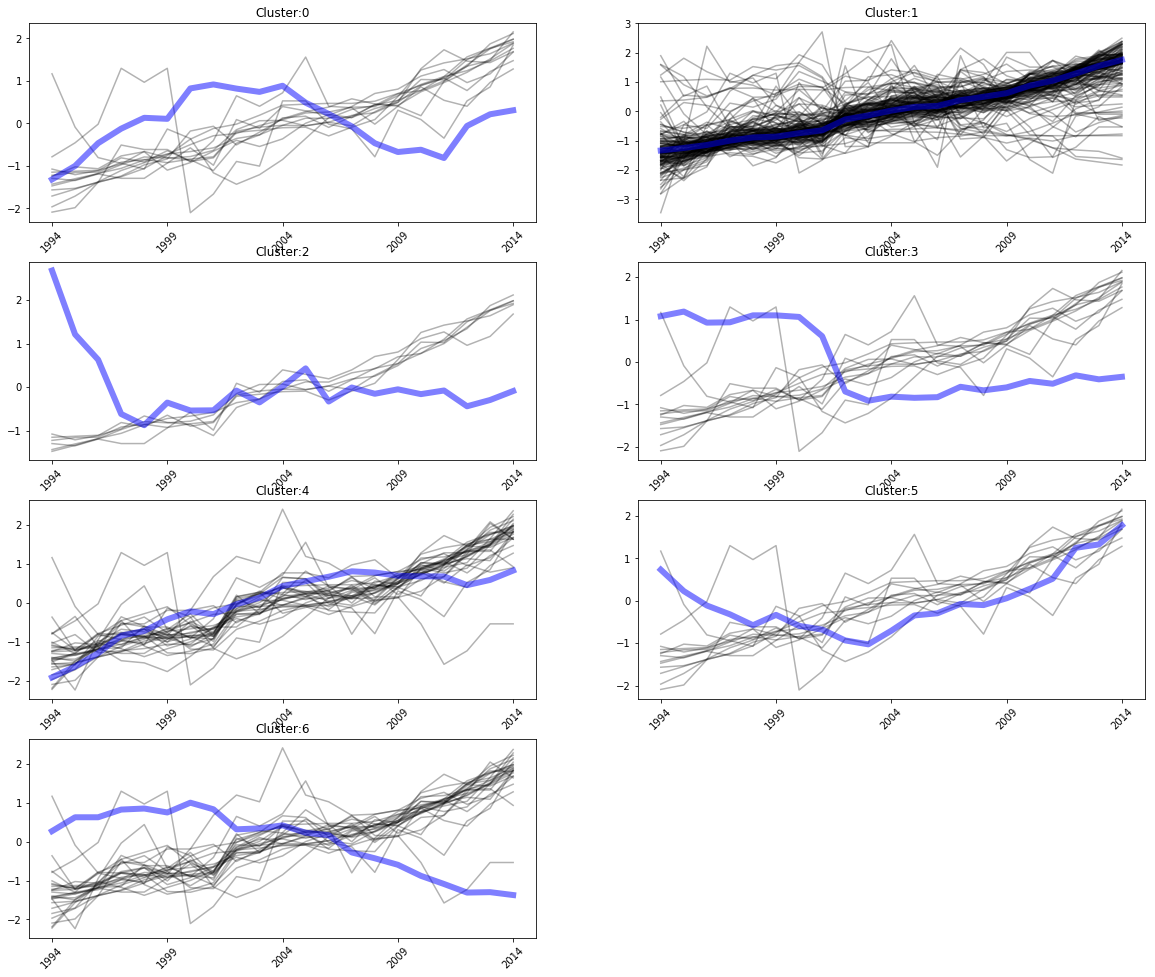

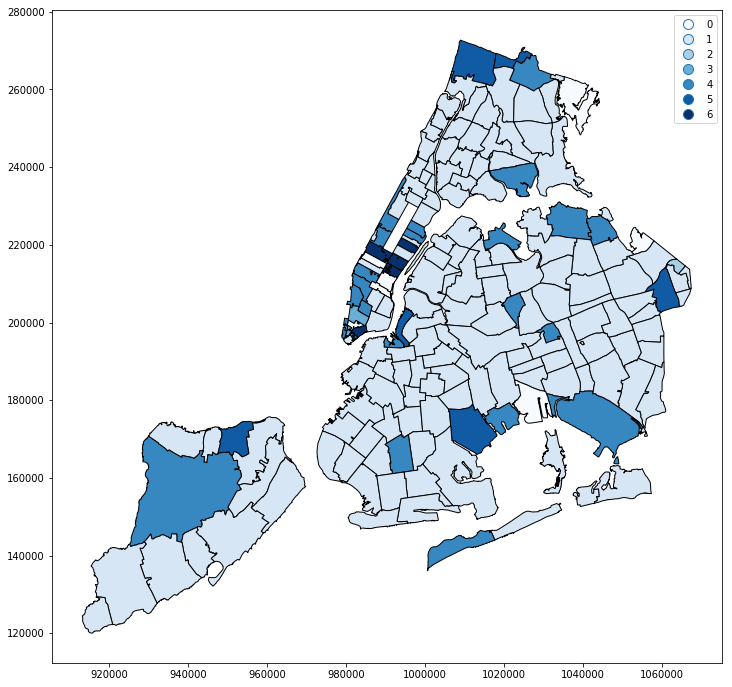

In [29]:
kmeansplot(7,vals,zipshp)

### figure 3: k-mean clustering of 5 for the establishments time series. 1,4,5 are increasing trends and 3,6 are decreasing trend. cloropleth of cluster centers for 7 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. there are seven types of blue

### I tried 3,5,7 kmeans of clustering, and choose 5 clusters which shows the trend but not too few or too much info

## 4. Use another clustering algorithm （Hierarchical agglomerative clustering）

In [38]:
nc=5
agc = AgglomerativeClustering(n_clusters=nc, linkage='average').fit(vals)
labelsag = agc.labels_
#centroidsag = np.zeros((nc, vals.shape[1]))

In [44]:
def agcplot(nc, vals,zipshp, random_state=444):
    #km = KMeans(n_clusters=nc, random_state=random_state).fit(vals)
    agc = AgglomerativeClustering(n_clusters=nc, linkage='average').fit(vals)
    
    agc_label = pd.DataFrame(agc.labels_)
    
    pl.figure(figsize=(20,30))
    
    for i in range(nc):
        agc_df = vals[agc.labels_ == i]
        means = agc_df.mean(axis=0)
        
        pl.subplot(7,2,i+1)
        for j in range(len(agc_df)):
            pl.plot(range(21), vals.irow(j)[:21],'black', alpha=0.3)
        pl.plot(range(21), means[:21], 'blue', alpha=0.5,linewidth=6)
        pl.xticks(arange(0,21,5), arange(1994,2015,5), rotation=45)
        pl.title('AG Cluster:%s'%i)
        
    agl_label_zip = agc_label.copy()
    agl_label_zip.index = vals.index
    agl_label_zip.columns= ['km%d'%nc]
    agl_label_zip.reset_index(inplace=True)
    agl_label_zip.rename(columns = {'zip' : 'ZIPCODE'}, inplace=True)
    agl_label_zip['ZIPCODE'] = agl_label_zip['ZIPCODE'].astype('str')
    nycshp = pd.merge(zipshp,agl_label_zip, on='ZIPCODE',how='inner')
    
    #cp.choroplethNYC(nycshp, column='km%d'%nc,cmap='Blues')
    pl.figure(figsize=(12,12))
    ax = pl.subplot(111)
    nycshp.plot(column='km%d'%nc,edgecolor='black', cmap="Blues", categorical=True, legend=True,ax=ax)
    

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: irow(i) is deprecated. Please use .iloc[i]


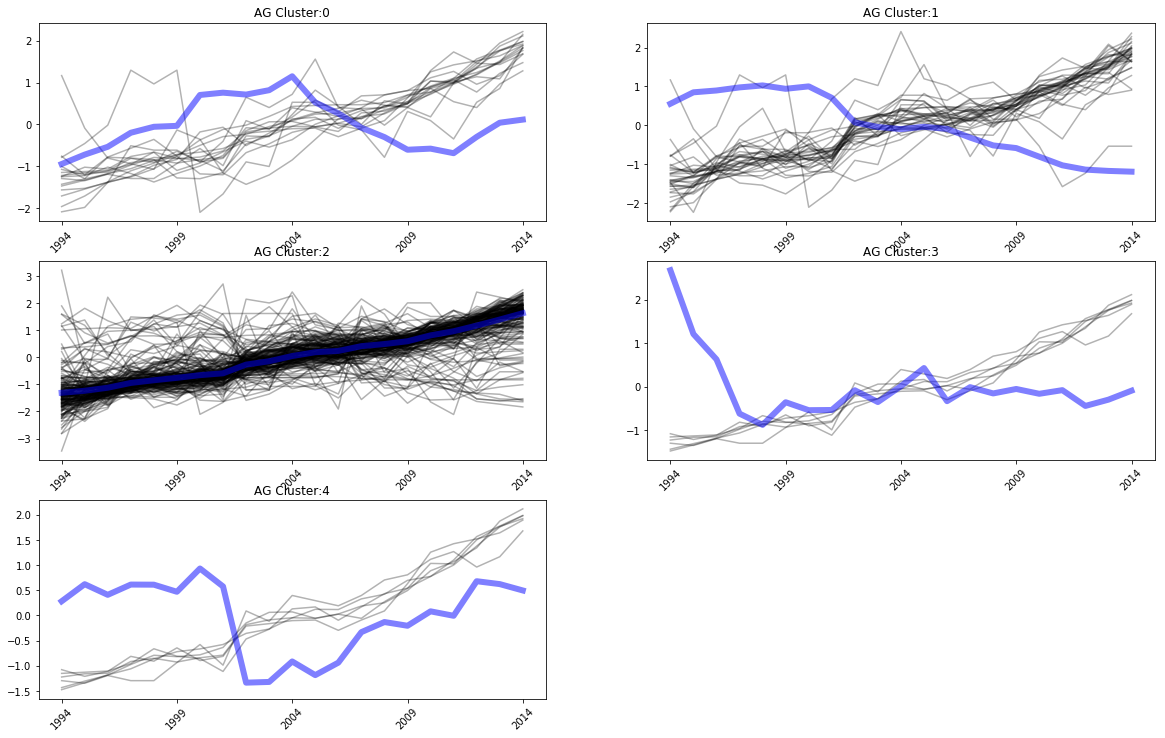

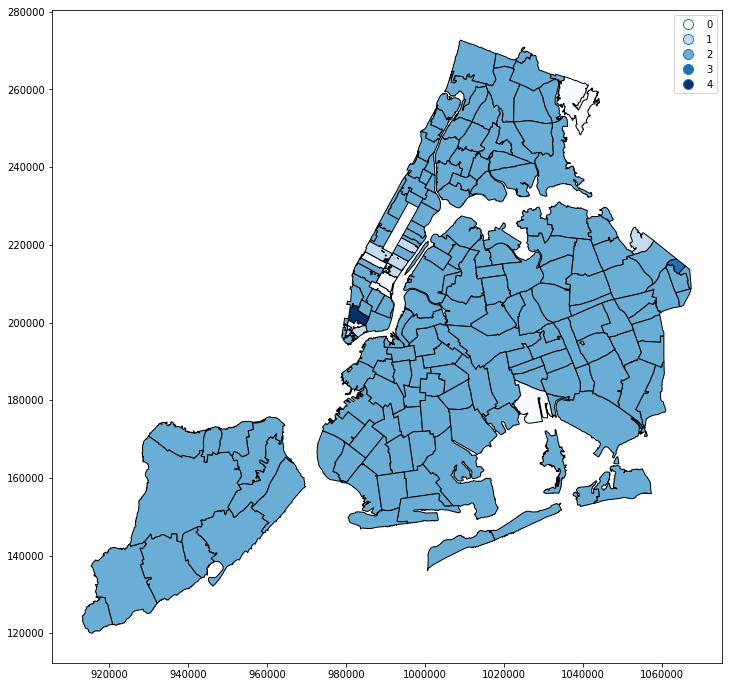

In [46]:
agcplot(5, vals, zipshp)

### figure 4: Hierarchical agglomerative clustering of 5 for the establishments time series. 0,2 are increasing trend and 1 and 3 are decreasing trend. cloropleth of cluster centers for 5 Hierarchical agglomerative clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster., there are five types of blue

(array([   5,   15,   25,   35,   45,   55,   65,   75,   85,   95,  105,
         115,  125,  135,  145,  155,  165,  175,  185,  195,  205,  215,
         225,  235,  245,  255,  265,  275,  285,  295,  305,  315,  325,
         335,  345,  355,  365,  375,  385,  395,  405,  415,  425,  435,
         445,  455,  465,  475,  485,  495,  505,  515,  525,  535,  545,
         555,  565,  575,  585,  595,  605,  615,  625,  635,  645,  655,
         665,  675,  685,  695,  705,  715,  725,  735,  745,  755,  765,
         775,  785,  795,  805,  815,  825,  835,  845,  855,  865,  875,
         885,  895,  905,  915,  925,  935,  945,  955,  965,  975,  985,
         995, 1005, 1015, 1025, 1035, 1045, 1055, 1065, 1075, 1085, 1095,
        1105, 1115, 1125, 1135, 1145, 1155, 1165, 1175, 1185, 1195, 1205,
        1215, 1225, 1235, 1245, 1255, 1265, 1275, 1285, 1295, 1305, 1315,
        1325, 1335, 1345, 1355, 1365, 1375, 1385, 1395, 1405, 1415, 1425,
        1435, 1445, 1455, 1465, 1475, 

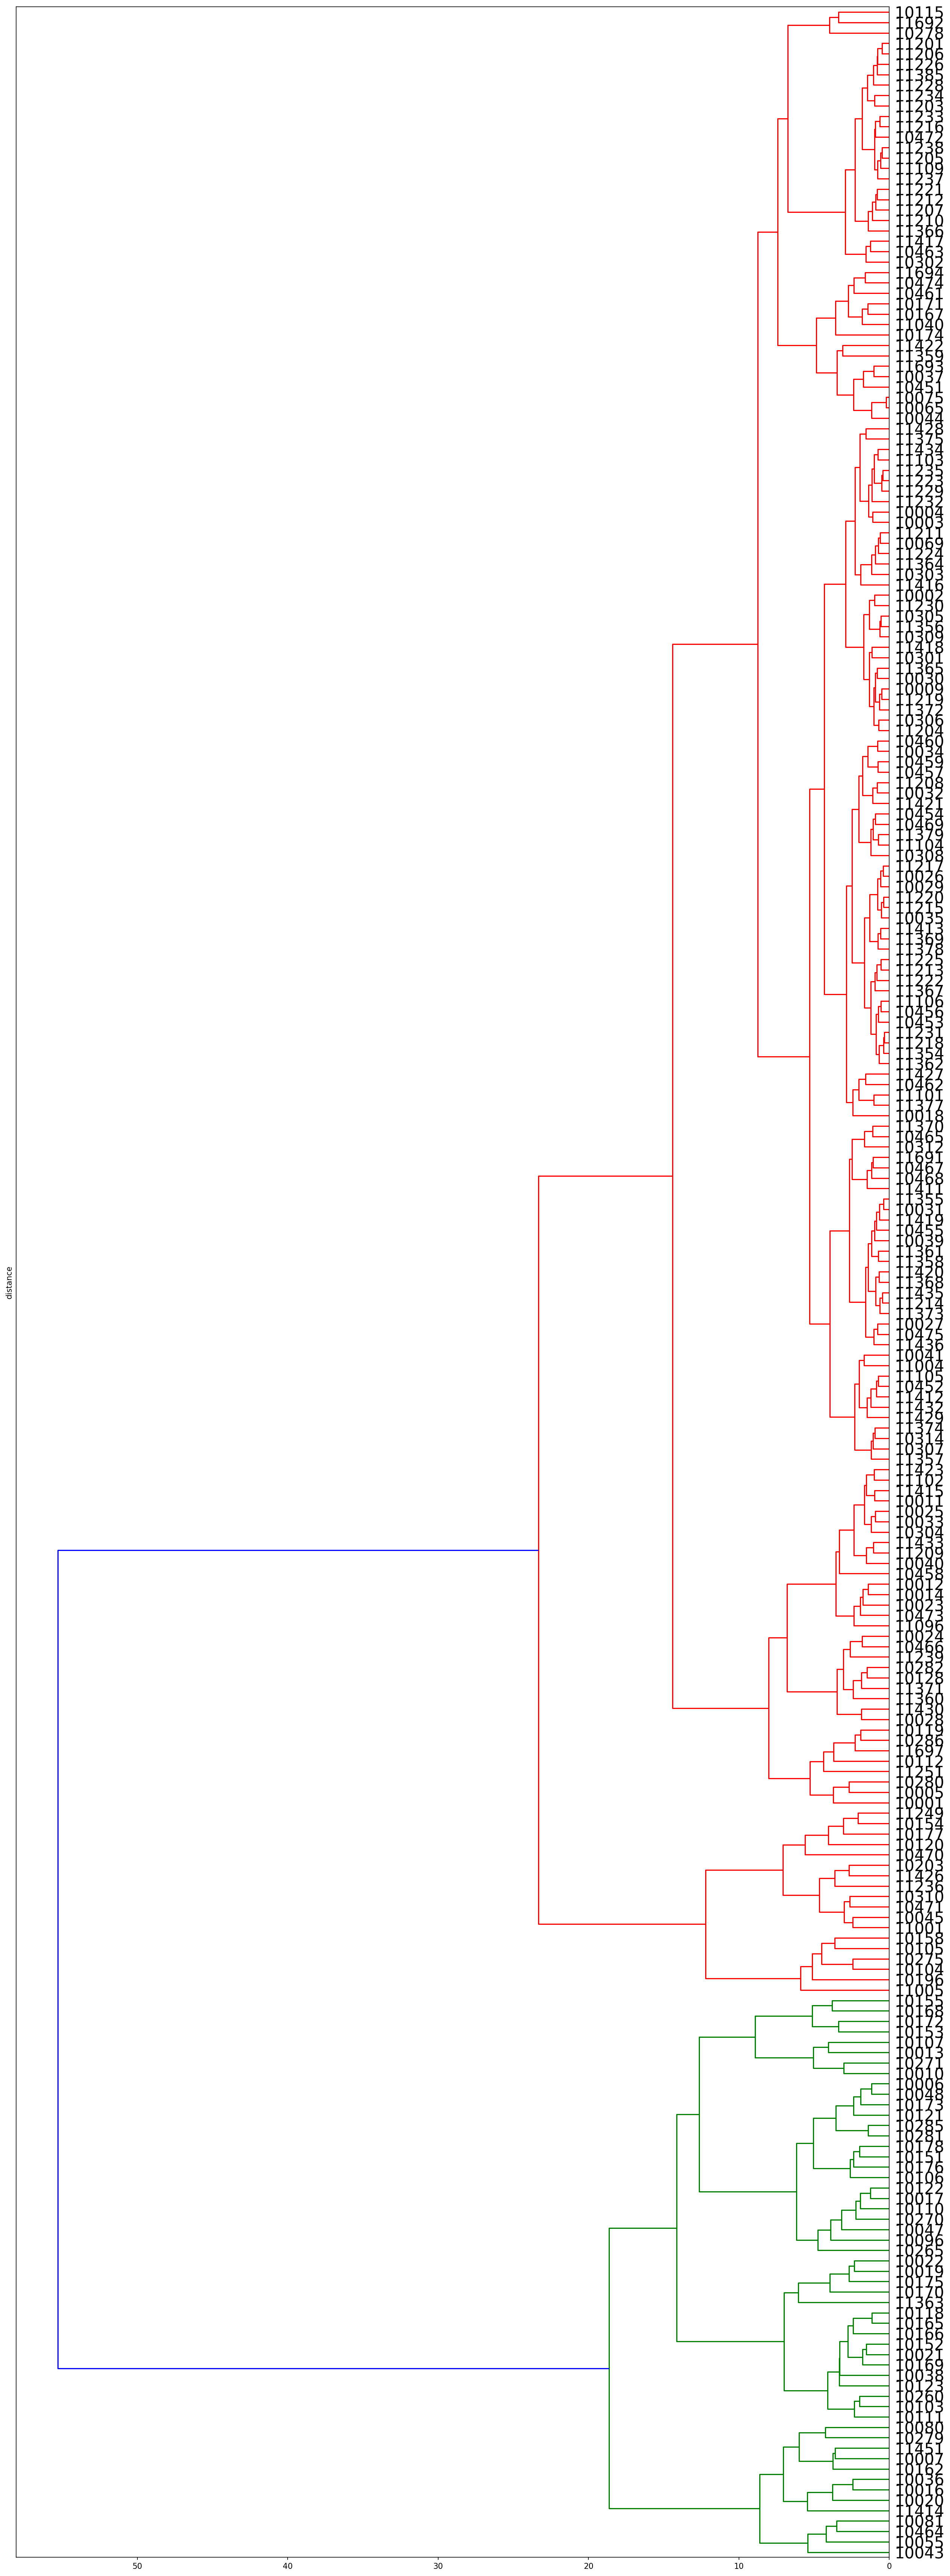

In [47]:
fig = pl.figure(figsize=(20,60), dpi=150)
pl.ylabel("distance")
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(vals, method='ward'),
                               labels = vals.index,
                               leaf_rotation=90.,  # rotates the x axis labels
                               leaf_font_size=8.,
                              orientation='left')  # font size for the x axis labels)
pl.yticks(rotation=0,fontsize=20)

### figure 5: dandrogram of hierarchical agglomerative clustering

## 5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters


In [48]:
km = KMeans(n_clusters=5, random_state=444).fit(vals)
km_label_nc = pd.DataFrame(km.labels_)
km_label_zip = km_label_nc.copy()
km_label_zip.index = vals.index
km_label_zip.columns= ['km%d'%nc]
km_label_zip.reset_index(inplace=True)
km_label_zip.rename(columns = {'zip' : 'ZIPCODE'}, inplace=True)
km_label_zip['ZIPCODE'] = km_label_zip['ZIPCODE'].astype('str')
kmshp = pd.merge(zipshp,km_label_zip, on='ZIPCODE',how='inner')

#cp.choroplethNYC(kmshp, column='km%d'%nc, cmap='Paired')

agc = AgglomerativeClustering(n_clusters=5, linkage='average').fit(vals)

agc_label = pd.DataFrame(agc.labels_)
agl_label_zip = agc_label.copy()
agl_label_zip.index = vals.index
agl_label_zip.columns= ['km%d'%nc]
agl_label_zip.reset_index(inplace=True)
agl_label_zip.rename(columns = {'zip' : 'ZIPCODE'}, inplace=True)
agl_label_zip['ZIPCODE'] = agl_label_zip['ZIPCODE'].astype('str')
agcshp = pd.merge(zipshp,agl_label_zip, on='ZIPCODE',how='inner')

#cp.choroplethNYC(agcshp, column='km%d'%nc,cmap='Paired')

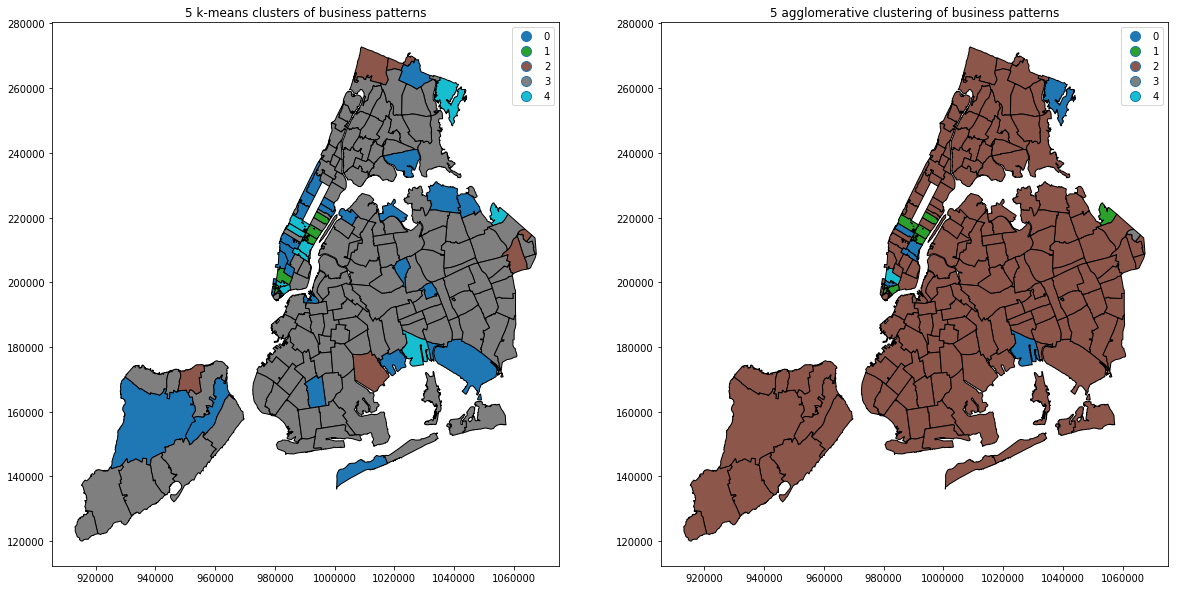

In [49]:
pl.figure(figsize=(20,10))
ax1= pl.subplot(121)
ax1 = kmshp.plot(column='km%d'%nc,edgecolor='black', categorical=True, legend=True,ax=ax1)
ax1.set_title('5 k-means clusters of business patterns')

ax2 = pl.subplot(122)
ax2 = agcshp.plot(column='km%d'%nc,edgecolor='black', categorical=True, legend=True,ax=ax2)
ax2.set_title('5 agglomerative clustering of business patterns')

pl.show()

### figure 6: comparing of the 5 k-means and hierarchical agglomerative clustering on the pattern of establishments on the level of NYC zipcode on the map

## 6. Compare the results of the 2 algorithms

Through the clustering trend, we see that the increasing and decreasing trend are general simailiar for those 2 algorithms. However, 5 kmeans of cluster 2 is atucally have the same trend as the hierarchical agglomerative clustering of third cluster. So on the map, we see that the majority is recognized as the second cluster by 5 kmeans clustering and the third cluster is consdiered to be the majority in ag clustering. But both show the majority region are in the increasing trend since we the cluster are on the increasing trends. For cluster 1, in decreasing trend, are both recognized by the two algorithms in same regions.

## 7. attempt an interpretation

Upon from our clustering on the times series analysis, we see that the most regions of manhattan's business establishments are on the increasing trends. Both algorithms show the increasing trends in staten island, brooklyn, bronx, and uptown. For some areas in manhattan show the stable and little increasing trends, we could conclude this was due to the saturation, the increasing would be stable and slow.